In [1]:
# check whether RF experiments can reproduce paper results
# check whether figures are exactly reproduced
# delete print statements from boxplot visualisations
# check whether in atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count_dict[atom_id > 0 else 0 the second part is unnecessary, simplify for atom_id in current_atom_id_to_count.keys(): atom_id_to_support_list[atom_id][k] = 1 further


# make optimised sort and slice feature extractor function (how break ties, how atom invariants, ...)
# check whether optimised sort and slice feature extractor leads to similar results as in my experiments

# design readme file and embedd figures
# link to the paper in readme file
# give instructions/code/functions on how to easily use sort and slice in other projects


# ideas:
# research project: extract features from target space to see if it improves out-of-distribution-generalisation
# generate ecfps that are calibrated to entire chemical space (paper of all molecules)



In [1]:
import numpy as np
from rdkit.Chem import rdFingerprintGenerator

import pandas as pd
from rdkit import Chem

In [51]:
def construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                             max_radius = 2, 
                                             pharm_atom_invs = False, 
                                             bond_invs = True, 
                                             chirality = False, 
                                             sub_counts = False, 
                                             vec_dimension = 1024):
    """
    Creates a function "ecfp_featuriser" that maps RDKit mol objects to vectorial ECFP fingerprints pooled via Sort & Slice (instead of traditional hash-based folding for substructure pooling).
    See also "Sort & Slice: A Simple and Superior Alternative to Hash-Based Folding for Extended-Connectivity Fingerprints" by Dablander, Hanser, Lambiotte and Morris (2024): https://arxiv.org/abs/2403.17954.
    
    INPUTS:
    
    - mols_train (list)        ...    A list of RDKit mol objects [mol_1, mol_2, ...] that are used as the training set to calibrate the Sort & Slice substructure pooling operator.
    - max_radius (int)         ...    The maximal radius up to which to generate the hashed integer ECFP-substructure identifiers. Common choices are 1, 2 or 3 (corresponding to diameters of 2, 4, or 6).
    - pharm_atom_invs (bool)   ...    If False, then the standard initial atomic invariants from RDKit (including ring membership) are used to generate the ECFPs; if True, then instead binary pharmacophoric initial atomic invariants are used to generate FCFPs.
    - bond_invs (bool)         ...    Whether or not to take into account bond invariants when generating the hashed integer ECFP-substructure identifiers (default = True).
    - chirality (bool)         ...    Whether or not to take into account chirality when generating the hashed integer ECFP-substructure identifiers (default = False).
    - sub_counts (bool)        ...    Whether ecfp_featuriser should generate binary vectorial fingerprints (sub_counts = False) that indicate the mere presence or absence of substructures, or integer fingerprints (sub_counts = True) that additionally indicate how many times a substructure is found in the input compound.
    - vec_dimension (int)      ...    Length of the vectorial Sort & Slice ECFP. Common choices are 512, 1024, 2048 and 4096. Only the vec_dimension most prevalent ECFP-substructures in mols_train are included in the final vector representation.
    
    OUTPUT:
    
    - ecfp_featuriser (function)    ...    A function that maps RDKit mol objects to vectorial ECFP fingerprints via a Sort & Slice substructure pooling operator trained on mols_train.
    
    EXAMPLE:
    
    First construct a molecular featurisation function with desired settings, for instance via
    
    ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train = [mol_1, mol_2, ...], 
                                                               max_radius = 2, 
                                                               pharm_atom_invs = False, 
                                                               bond_invs = True, 
                                                               chirality = False, 
                                                               sub_counts = False, 
                                                               vec_dimension = 1024)
                                                               
    Note that the ECFP settings (max_radius, pharm_atom_invs, bond_invs, chirality, sub_counts, vec_dimension) and chemical information from mols_train are all by construction implicitly transferred to "ecfp_featuriser".
    
    Now let mol be an RDKit mol object. Then ecfp_featuriser(mol) is a 1-dimensional numpy array of length "vec_dimension" representing the vectorial Sort & Slice ECFP fingerprint for mol.
    
    The fingerprint ecfp_featuriser(mol) is generated by (i) first generating the (multi)set of hashed integer ECFP-substructure identifiers from mol and then (ii) vectorising it via the Sort & Slice operator trained on mols_train (rather than vectorising it via classical hash-based folding).
    """
    
    # create substructure enumerator function that maps a mol object to a dictionary whose keys are all the integer substructure identifiers identified in mol and whose values are the associated substructure counts in mol (i.e., how often each substructure appears in mol)
    morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius = max_radius,
                                                                 atomInvariantsGenerator = rdFingerprintGenerator.GetMorganFeatureAtomInvGen() if pharm_atom_invs == True else rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True),
                                                                 useBondTypes = bond_invs,
                                                                 includeChirality = chirality)
    
    sub_id_enumerator = lambda mol: morgan_generator.GetSparseCountFingerprint(mol).GetNonzeroElements()
    
    # construct dictionary that maps each integer substructure identifier sub_id in mols_train to its associated prevalence (i.e., to the total number of compounds in mols_train that contain sub_id at least once)
    sub_ids_to_prevs_dict = {}
    for mol in mols_train:
        for sub_id in sub_id_enumerator(mol).keys():
            sub_ids_to_prevs_dict[sub_id] = sub_ids_to_prevs_dict.get(sub_id, 0) + 1

    # create list of integer substructure identifiers sorted by prevalence in mols_train (ties are broken using the arbitrary ordering induced by the integer substructure identifiers themselves)
    sub_ids_sorted_list = sorted(sub_ids_to_prevs_dict, key = lambda sub_id: (sub_ids_to_prevs_dict[sub_id], -sub_id), reverse = True)
    
    # create auxiliary function that generates standard unit vectors in numpy
    def standard_unit_vector(dim, k):
        
        vec = np.zeros(dim, dtype = int)
        vec[k] = 1
        
        return vec
    
    # create one-hot encoder for the first vec_dimension substructure identifiers in sub_ids_sorted_list; all other substructure identifiers are mapped to a vector of 0s
    def sub_id_one_hot_encoder(sub_id):
        
        return standard_unit_vector(vec_dimension, sub_ids_sorted_list.index(sub_id)) if sub_id in sub_ids_sorted_list[0: vec_dimension] else np.zeros(vec_dimension)
    
    # create a function ecfp_featuriser that maps RDKit mol objects to vectorial ECFP fingerprints via a Sort & Slice substructure pooling operator trained on mols_train
    def ecfp_featuriser(mol):

        # create list of integer substructure identifiers contained in input mol object (multiplied by how often they appear in mol if sub_counts = True)
        if sub_counts == True:
            sub_id_list = [sub_id for (sub_id, count) in sub_id_enumerator(mol).items() for sub_id in [sub_id]*count]
        else:
            sub_id_list = list(sub_id_enumerator(mol).keys())
        
        # create molecule-wide vectorial representation by summing up one-hot encoded substructure idenfitiers
        ecfp_vector = np.sum(np.array([sub_id_one_hot_encoder(sub_id) for sub_id in sub_id_list]), axis = 0)
    
        return ecfp_vector
    
    print("Number of compounds in molecular training data set = ", len(mols_train))
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(sub_ids_to_prevs_dict))

    return ecfp_featuriser

In [83]:
mols_train = [Chem.MolFromSmiles(smiles) for smiles in x_smiles]*1

In [89]:
%%time
ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                                           max_radius = 2, 
                                                           pharm_atom_invs = False, 
                                                           bond_invs = True, 
                                                           chirality = False, 
                                                           sub_counts = False, 
                                                           vec_dimension = 1024)

Number of compounds in molecular training data set =  4200
Number of unique circular substructures with specified parameters in molecular training data set =  15871
CPU times: user 245 ms, sys: 36 µs, total: 245 ms
Wall time: 245 ms


In [77]:
%%time
X = np.array([ecfp_featuriser(mol) for mol in mols_train])

print(X.shape)
print(X[0:15,0:15])

(33600, 512)
[[1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]]
CPU times: user 8.68 s, sys: 80.1 ms, total: 8.76 s
Wall time: 8.78 s


# Import Packages

In [1]:
# import general packages and set general options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.8258])


# Load and Prepare Data

In [2]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [3]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [3]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [3]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [3]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [3]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [4]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

,SMILES,exp
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,COC(=O)[C@H](c1ccccc1Cl)N1CCc2c(ccs2)C1,3.69
3,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2c([nH...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,3.10
...,...,...
4195,O=C(Nc1ccc(CCO)cc1)c1cc2cc(Cl)ccc2[nH]1,3.85
4196,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
4197,COc1cccc2c1cn[nH]2,2.10
4198,O=C(NCC1CCCCC1)c1c2cccnc2ccc1Cl,2.65


In [5]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Mean Value (Target) =  2.1863357142857143
Standard Deviation (Target) =  1.2028604901336188
Maximum Value (Target) =  4.5
Minimum Value (Target) =  -1.5 

Shape of y =  (4200,)

 y =  [ 3.54 -1.18  3.69 ...  2.1   2.65  2.7 ]


NameError: name 'plt' is not defined

Shape of x_smiles =  (4200,)
Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21


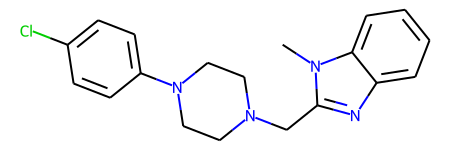

In [6]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [7]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [8]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "rand" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [10]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [11]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 3, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "filtered", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 512, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [12]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [13]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [14]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 0,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [15]:
%%time
# run model and save results

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

Number of unique circular substructures with specified parameters in molecular training data set =  12930
0 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.466946,0.329693,0.634466,2.335452,0.402547,0.793937,0.630141,962.0


Number of unique circular substructures with specified parameters in molecular training data set =  12955
0 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.45468,0.303246,0.662613,3.995515,0.439056,0.774496,0.598259,962.0


Number of unique circular substructures with specified parameters in molecular training data set =  12751
1 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.475331,0.328218,0.675553,3.149796,0.456372,0.756665,0.571632,962.0


Number of unique circular substructures with specified parameters in molecular training data set =  13195
1 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.478709,0.33357,0.670148,3.672475,0.449098,0.773471,0.596949,962.0


Number of unique circular substructures with specified parameters in molecular training data set =  13028
2 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.451652,0.304947,0.631808,2.601031,0.399181,0.795562,0.630601,962.0


Number of unique circular substructures with specified parameters in molecular training data set =  12806
2 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.468921,0.332077,0.667427,4.382251,0.445458,0.77253,0.595276,962.0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
"(0, 0)",0.466946,0.329693,0.634466,2.335452,0.402547,0.793937,0.630141,962.0
"(0, 1)",0.454680,0.303246,0.662613,3.995515,0.439056,0.774496,0.598259,962.0
"(1, 0)",0.475331,0.328218,0.675553,3.149796,0.456372,0.756665,0.571632,962.0
"(1, 1)",0.478709,0.333570,0.670148,3.672475,0.449098,0.773471,0.596949,962.0
"(2, 0)",0.451652,0.304947,0.631808,2.601031,0.399181,0.795562,0.630601,962.0
"(2, 1)",0.468921,0.332077,0.667427,4.382251,0.445458,0.772530,0.595276,962.0
mean,0.466040,0.321959,0.657002,3.356087,0.431952,0.777777,0.603809,962.0
std,0.009933,0.012753,0.017319,0.732159,0.022590,0.013417,0.020806,0.0


CPU times: user 1min 45s, sys: 186 ms, total: 1min 45s
Wall time: 1min 45s


In [21]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["hashed", "filtered", "mim", "sort_and_slice"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles[ind_train], 
                                                        y_train = y[ind_train], 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles[ind_train])
                    X_test = featuriser(x_smiles[ind_test])
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y[ind_train])
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

NameError: name 'a' is not defined

# Results Visualisation

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

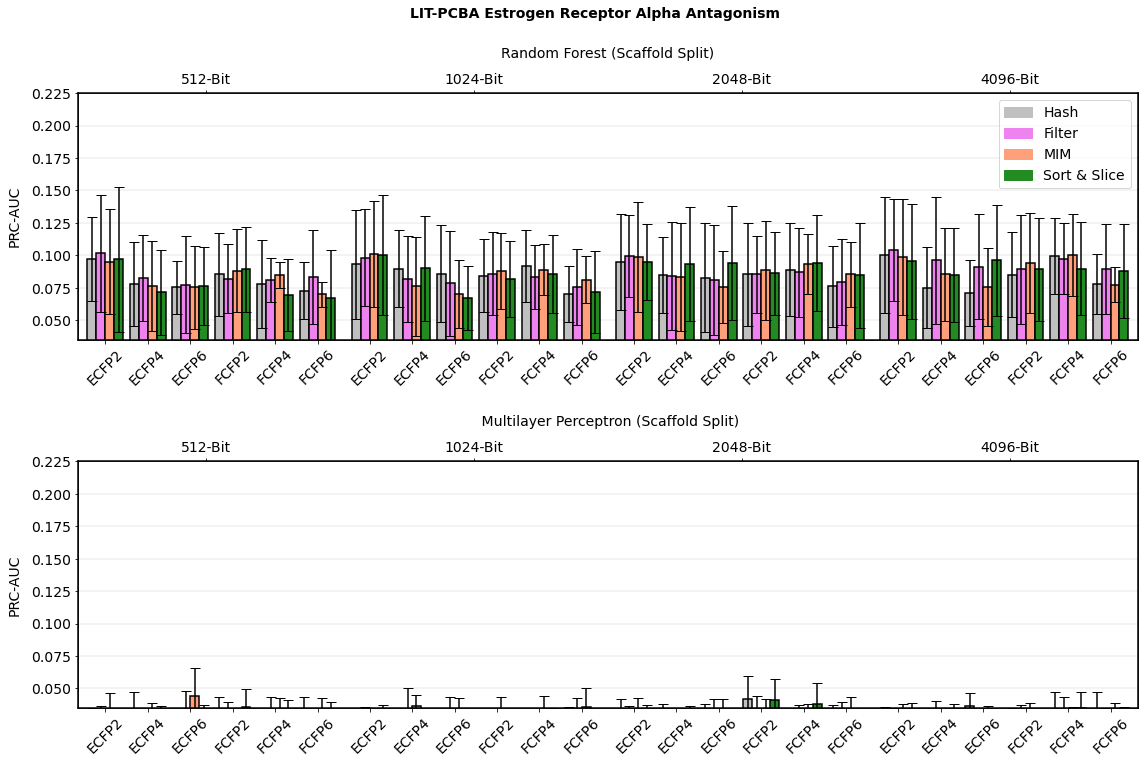

In [17]:
visualise_bar_charts(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                     split_type = "scaff", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "PRC-AUC", # specify performance metric,
                     y_lims = (0.04, 0.22), # specify limits of y-axis
                     y_unit = "") # specify unit for y-axis (if applicable)

[0.6943113  0.67138541 0.67619072 0.66443731]
[0.02756505 0.00958823 0.0105218  0.0079305 ] 

[2.28492741 2.28420768 2.28301158 2.28527163]
[0.01031733 0.00935966 0.00923131 0.00953502] 

[0.78911411 0.76414295 0.76716133 0.75921402]
[0.03025863 0.01025566 0.01113869 0.00998105] 

[2.28390647 2.28231618 2.28540368 2.28267008]
[0.01009871 0.00908055 0.011557   0.00912546] 



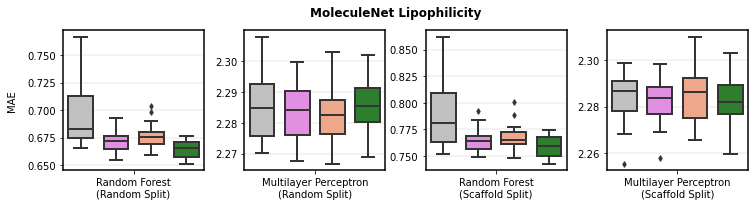

In [2]:
visualise_box_plots(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.6943113  0.67127701 0.67619072 0.66443731]
[0.02756505 0.00957752 0.0105218  0.0079305 ] 

[0.62236537 0.61955433 0.63387084 0.58571558]
[0.0307138  0.04259825 0.04632885 0.01755706] 

[0.78911411 0.76399427 0.76716133 0.75921402]
[0.03025863 0.01033125 0.01113869 0.00998105] 

[0.72976848 0.7176687  0.73152845 0.68644593]
[0.03540535 0.04543928 0.04920788 0.0162422 ] 



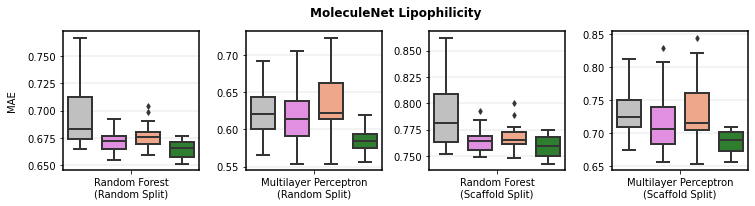

In [8]:
visualise_box_plots(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[1.0542911  1.0359621  1.04762288 1.01703795]
[0.04154548 0.03820795 0.03718237 0.04269807] 

[3.09127353 3.08464279 3.09184814 3.09044687]
[0.011262   0.01008861 0.00948151 0.00986685] 

[1.46324735 1.44543404 1.44714147 1.44234641]
[0.04337977 0.03924765 0.03702334 0.03458364] 

[3.08154613 3.08297812 3.08318354 3.0841692 ]
[0.00825683 0.0133107  0.01139718 0.00949274] 



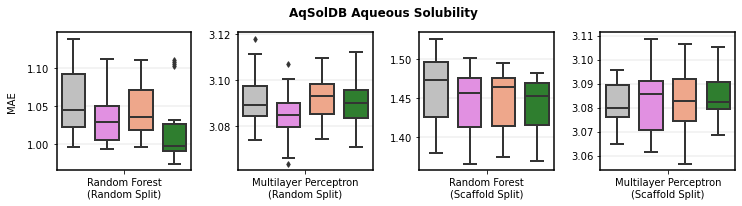

In [4]:
visualise_box_plots(dataset_name = "aqsoldb_solubility", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[1.0542911  1.03592195 1.04762288 1.01703795]
[0.04154548 0.03825885 0.03718237 0.04269807] 

[0.98090504 0.98281228 1.00501333 0.94282763]
[0.05068442 0.05689927 0.05312542 0.067684  ] 

[1.46324735 1.44582904 1.44714147 1.44234641]
[0.04337977 0.03872475 0.03702334 0.03458364] 

[1.38777709 1.38319326 1.39633325 1.34827167]
[0.02074076 0.0314707  0.03301436 0.02925209] 



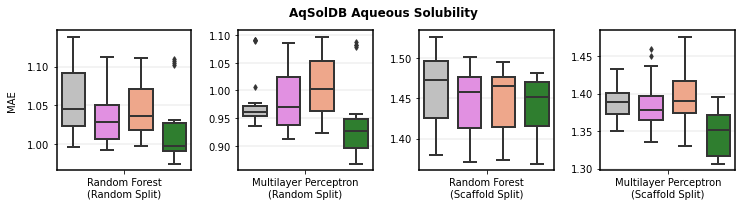

In [9]:
visualise_box_plots(dataset_name = "aqsoldb_solubility", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.46759588 0.46043889 0.46374356 0.45558306]
[0.0205431  0.02422072 0.02222179 0.02524791] 

[1.28787225 1.28943992 1.28946633 1.29278985]
[0.01467138 0.01309295 0.01024693 0.01278309] 

[0.52135321 0.51094241 0.51389563 0.5066434 ]
[0.02426253 0.02841335 0.02707582 0.03036748] 

[1.28922607 1.29137714 1.28960691 1.28754673]
[0.01444766 0.01004995 0.01358591 0.01289478] 



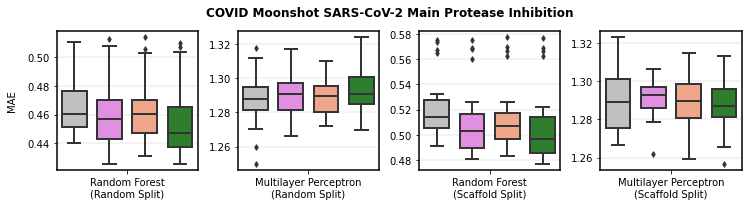

In [5]:
visualise_box_plots(dataset_name = "postera_sars_cov_2_mpro", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.46759588 0.46059158 0.46374356 0.45558306]
[0.0205431  0.02415372 0.02222179 0.02524791] 

[0.43073557 0.43585638 0.44046317 0.42870323]
[0.02085253 0.02257317 0.02215993 0.02259018] 

[0.52135321 0.51086323 0.51389563 0.5066434 ]
[0.02426253 0.02840367 0.02707582 0.03036748] 

[0.49342022 0.49293101 0.49856208 0.48536597]
[0.02301459 0.02497402 0.02359813 0.02638728] 



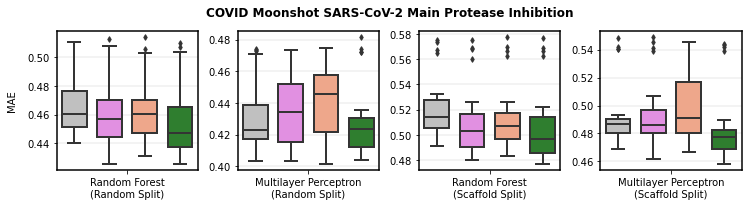

In [10]:
visualise_box_plots(dataset_name = "postera_sars_cov_2_mpro", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.85825828 0.85807262 0.8546457  0.86165991]
[0.00745945 0.00772895 0.00795403 0.00761454] 

[0.49979945 0.49978703 0.49727559 0.50006485]
[0.00500848 0.0077669  0.00807868 0.00734304] 

[0.79770075 0.80293991 0.80087869 0.80637585]
[0.0094547  0.00840415 0.00888922 0.00794913] 

[0.50033877 0.50133772 0.50073496 0.49982184]
[0.0059993  0.00671266 0.00801644 0.00713919] 



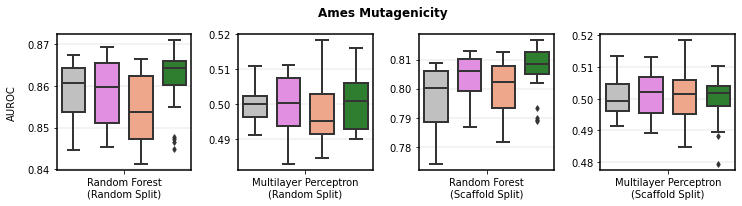

In [6]:
visualise_box_plots(dataset_name = "ames_mutagenicity", # specify dataset name
                    metric = "AUROC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.85825828 0.85808862 0.8546457  0.86165991]
[0.00745945 0.00774661 0.00795403 0.00761454] 

[0.83524983 0.83025964 0.82574286 0.83645157]
[0.00778474 0.00790497 0.00822153 0.00825732] 

[0.79770075 0.80295294 0.80087869 0.80637585]
[0.0094547  0.00842114 0.00888922 0.00794913] 

[0.77606099 0.77528969 0.77147962 0.78415447]
[0.01020726 0.00936401 0.01015735 0.0101085 ] 



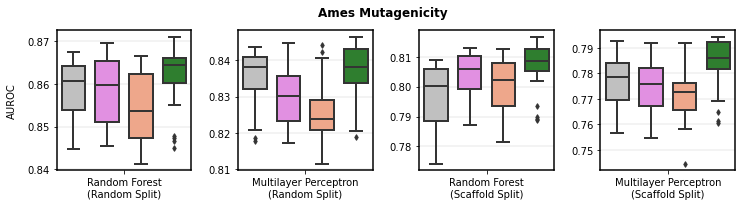

In [11]:
visualise_box_plots(dataset_name = "ames_mutagenicity", # specify dataset name
                    metric = "AUROC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.16213318 0.16880731 0.15891891 0.17237188]
[0.01788898 0.01525961 0.01780919 0.01422271] 

[0.02937391 0.03127104 0.0323402  0.0276578 ]
[0.00226066 0.00635131 0.00677974 0.00404944] 

[0.08423569 0.08602265 0.08317475 0.08674594]
[0.00871132 0.00563402 0.00933342 0.00968227] 

[0.0304809  0.03047675 0.02949303 0.02986514]
[0.00427665 0.00506341 0.00493331 0.00358534] 



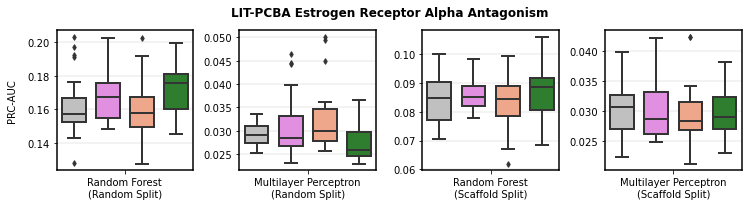

In [7]:
visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.16213318 0.16825282 0.15891891 0.17237188]
[0.01788898 0.01509173 0.01780919 0.01422271] 

[0.1262524  0.13054084 0.12201661 0.13828093]
[0.01212836 0.0120168  0.01313937 0.01455258] 

[0.08423569 0.0858784  0.08317475 0.08674594]
[0.00871132 0.00578098 0.00933342 0.00968227] 

[0.05868495 0.05990317 0.05691309 0.06029368]
[0.00900185 0.00720015 0.00966824 0.00884483] 



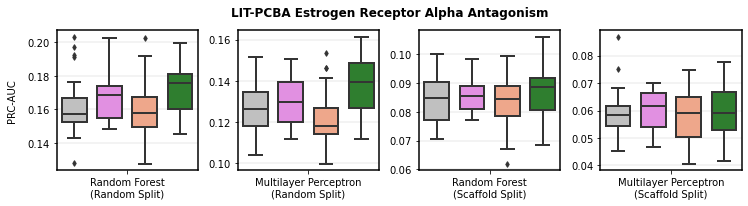

In [12]:
visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not